# Household energy consumption data analysis of ACORN A

## 0.0 Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
pd.set_option('mode.chained_assignment', None)

## 1.0 Data imports

Data import is from Kaggle:
https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london/data

In [4]:
# find path to full data set
import os
path = '/home/freddieoxland/code/hramzan01/market/raw_data'
path_data = path + '/halfhourly_dataset/halfhourly_dataset'
path_results = path + '/ACORN_A.csv'

## 2.0 Set up data base for storing data

In [5]:
# set up initial data base
df_A = pd.DataFrame(columns=['LCLid', 'tstp','energy(kWh/hh)','stdorToU','Acorn','Acorn_grouped','file'])
df_A.to_csv(path_results)


In [6]:
# load household info data
house_path = path + '/informations_households.csv'
house_data = pd.read_csv(house_path)
house_data.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


## 3.0 open each file and extract Acorn A data

In [3]:
from google.cloud import bigquery
import os

client = bigquery.Client.from_service_account_json(json_credentials_path=os.environ['GOOGLE_APPLICATION_CREDENTIALS'])

In [ ]:
# Define your SQL query to join the two tables
sql_query = """
SELECT hour.*, house.*
FROM your_dataset.hour_data AS hour
LEFT JOIN your_dataset.house_data AS house
ON hour.LCLid = house.LCLid
"""

# Execute the query
query_job = client.query(sql_query)

# Fetch the results into a DataFrame
data_merged = query_job.to_dataframe()

In [7]:
# need i = 112 for full data set
for i in range (11):
    # load each data entry
    hour_data = pd.read_csv(path_data + f'/block_{i}.csv')
    # merge the data with the acorn information
    data_merged = hour_data.merge(house_data, how = 'left', left_on='LCLid', right_on='LCLid')
    # find entries which are ACORN-A
    df_A = data_merged[data_merged['Acorn'] == 'ACORN-A']
    # remove null values
    df_A['energy(kWh/hh)'] = df_A['energy(kWh/hh)'].replace('Null', '0')
    # convert time to string and energy column to numerical values
    df_A['tstp'] = df_A['tstp'].astype("string")
    df_A['energy(kWh/hh)'] = df_A['energy(kWh/hh)'].apply(pd.to_numeric)

    # open the current Acorn A
    df_A_full = pd.read_csv(path_results)
    # concat the new data
    df_A_full = pd.concat([df_A_full,df_A])
    # save the new data
    df_A_full.to_csv(path_results)
    print(f'In progress {i+1} completed')

FileNotFoundError: [Errno 2] No such file or directory: '/home/freddieoxland/code/hramzan01/market/raw_data/halfhourfulldata/block_0.csv'

## 4.0 Take mean of each time and store

In [6]:
# find mean for each timestep
df_A_full=pd.read_csv(path_results)
df_A_timeseries = df_A_full.groupby('tstp')[['energy(kWh/hh)']].mean()

In [7]:
# reset index
df_A_timeseries.reset_index(inplace=True)

In [8]:
df_A_timeseries.rename(columns = {'tstp':'date','energy(kWh/hh)':'Average energy(kWh/hh)'}, inplace=True)
df_A_timeseries

,date,Average energy(kWh/hh)
0,2011-12-03 09:00:00.0000000,0.149000
1,2011-12-03 09:30:00.0000000,0.154000
2,2011-12-03 10:00:00.0000000,0.768000
3,2011-12-03 10:30:00.0000000,1.179000
4,2011-12-03 11:00:00.0000000,0.588000
...,...,...
39384,2014-02-27 22:00:00.0000000,0.570301
39385,2014-02-27 22:30:00.0000000,0.537257
39386,2014-02-27 23:00:00.0000000,0.487221
39387,2014-02-27 23:30:00.0000000,0.400015


## 5.0 Plot the new data

([<matplotlib.axis.XTick at 0x7fe8875c43d0>,
 [Text(0.0, 0, '2011-12-03 09:00:00.0000000'),
  Text(800.0, 0, '2014-02-07 10:00:00.0000000')])

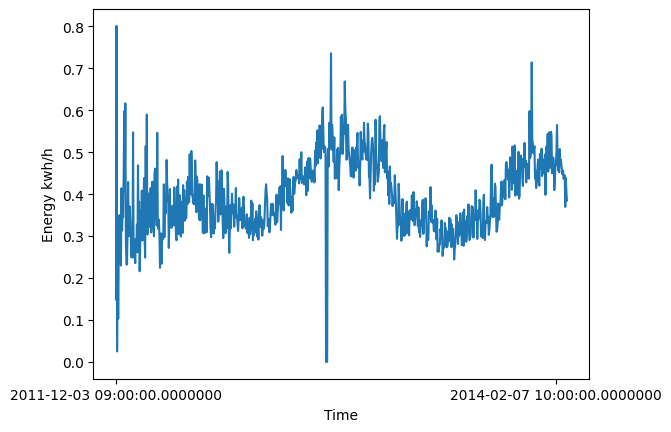

In [9]:
df_A_sampled = df_A_timeseries.iloc[::48, :]
plt.plot(df_A_sampled['date'], df_A_sampled['Average energy(kWh/hh)'])
plt.xlabel('Time')
plt.ylabel('Energy kwh/h')
plt.xticks([df_A_sampled['date'][0],df_A_sampled['date'][800*48]])

## 6.0 Save new dataframe

In [10]:
df_A_timeseries.to_csv(path + '/ACORN_A_processed.csv')